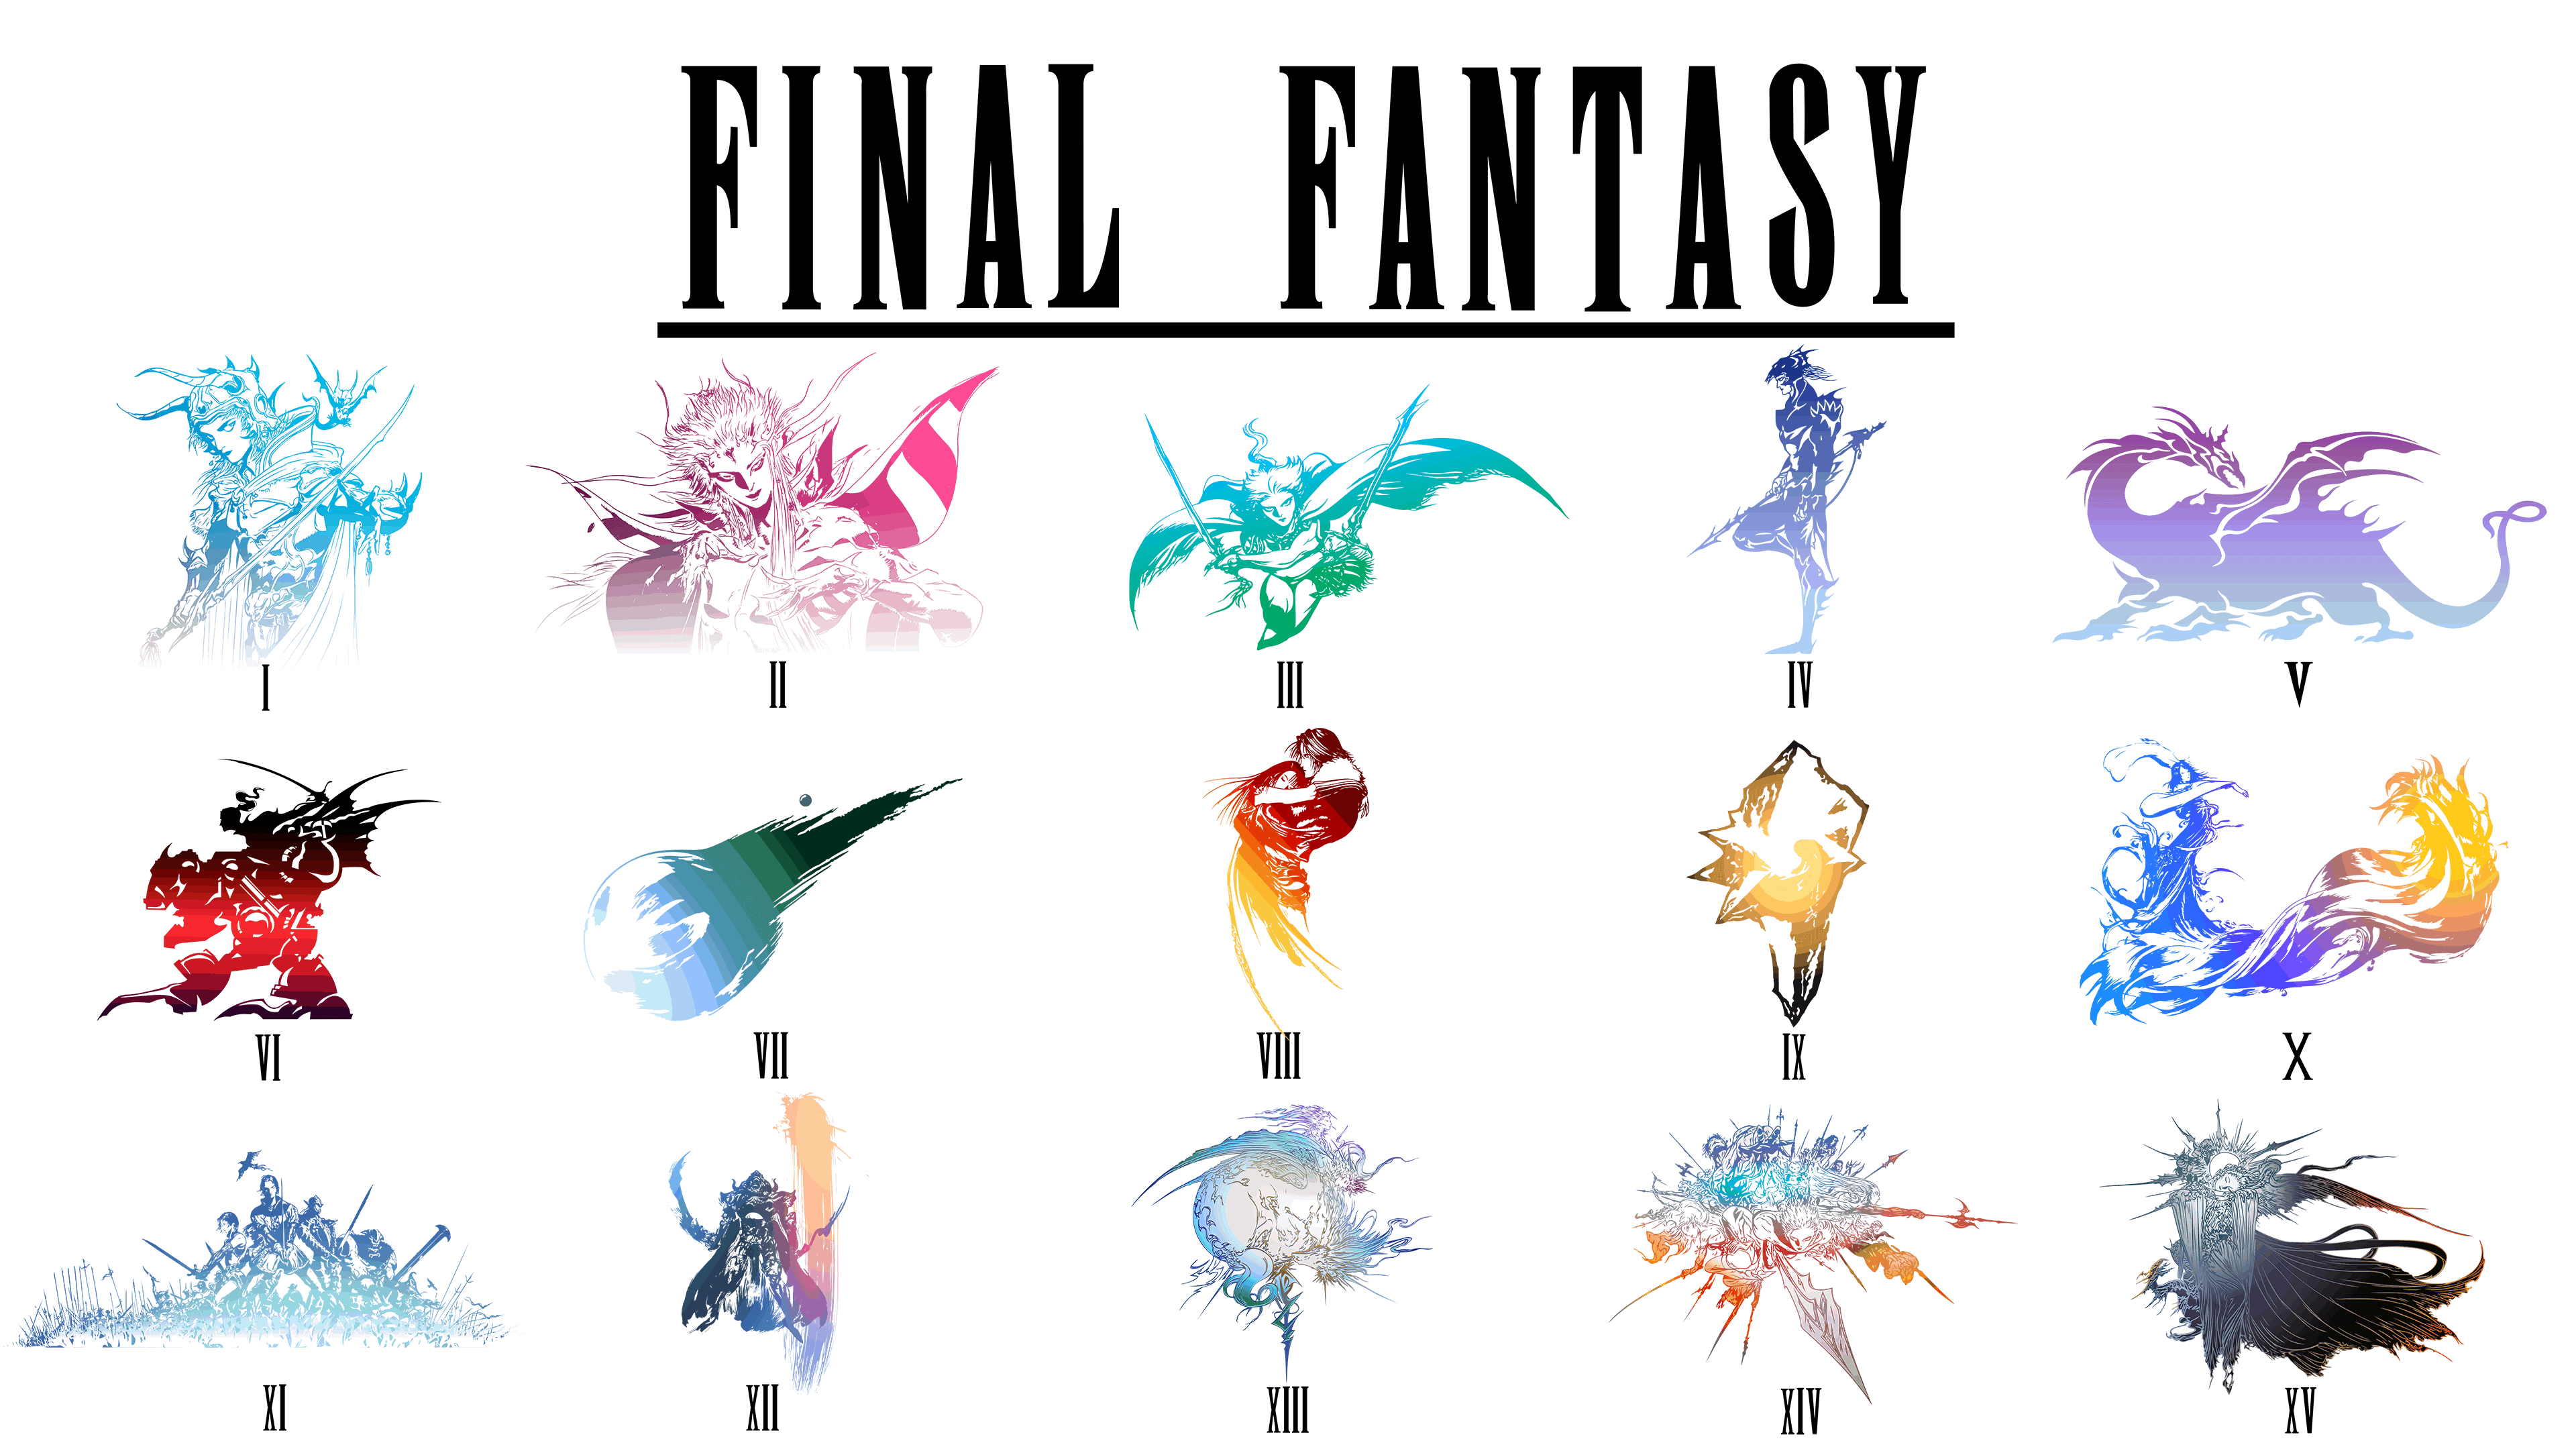

# Section A:  Problem Description
> What are we trying to do in this project?





***Users need more sophisticated ways to classify information for datasets that rely on more than just keywords, but can also use context clues. One new method introduced by our team is to evolve a language model that will be able to recognize more than just words, but also pick up on a character’s personality as well.***

***Our objective with the project is to make a language model that is able to quickly and accurately predict what character a person is roleplaying as. We want the model to appear like it is able to identify not just words, but the personality of the characters.***

# Section B: Dataset Preparation
> Provide a description of your data, print its dimension, visualize it if possible.



***The dataset we are going to be using for this project is a compilation of character quotes, and dialogue scripts. We’ll use an online dataset that has a list of compiled dialogue from the series (bit.ly/3wdpYJj).
At first this will be limited in scope in order to test how well the model is functioning, but once we have a solid foundation we can add more scripts and quotes to the training data in order to expand the list of possible characters for the user.***

We begin by importing the necesseties in order to run the model.
After this, we then import the dataset that we are using.

In [ ]:
!pip install accelerate -U
!pip install transformers[torch] -U

In [ ]:
import transformers
import accelerate

print("Transformers version:", transformers.__version__)
print("Accelerate version:", accelerate.__version__)

Transformers version: 4.40.1
Accelerate version: 0.29.3


In [ ]:
import torch
import os
import pandas as pd
from transformers import GPT2LMHeadModel
from transformers import GPT2Tokenizer, Trainer, TrainingArguments,  pipeline, BertForSequenceClassification, BertTokenizerFast
from huggingface_hub import notebook_login, HfApi, HfFolder
from torch.utils.data import Dataset

token = os.getenv('HF_TOKEN')
if token is None:
    print("Please set the HF_TOKEN environment variable.")
    notebook_login()
else:
    # Authenticate session
    from huggingface_hub import HfFolder
    HfFolder.save_token(token)

api = HfApi()
try:
    user_models = api.list_models(use_auth_token=token)
    model_list = list(user_models)  # Safely handle the generator
    print("Authentication successful! Number of accessible models: ", len(model_list))
except Exception as e:
    print("Failed to authenticate or retrieve models:", str(e))

Please set the HF_TOKEN environment variable.


Authentication successful! Number of accessible models:  618236


# Section C: Model Training
>Using Bert & GPT-2 to handle language input and classify characters based on dialogue dataset(s).


#(Section C part 1) GPT2 Layer

>Using pretrained Transformer model from huggingFace before tuning.

In [ ]:
model_name = 'gpt2'
gptTokenizer = GPT2Tokenizer.from_pretrained(model_name)
if gptTokenizer.pad_token is None:
    gptTokenizer.pad_token = gptTokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained(model_name)

In [ ]:
df = pd.read_csv('ff7-simplified.csv')
df['formatted_text'] = df['Character'] + ": " + df['Dialogue']

In [ ]:
training_data = gptTokenizer(df['formatted_text'].tolist(), add_special_tokens=True, return_tensors='pt', max_length=512, padding="max_length", truncation=True)


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings.input_ids)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = item['input_ids'].clone()
        return item


In [ ]:
dataset = CustomDataset(training_data)

In [ ]:
def calculate_perplexity(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients for evaluation
        for batch in dataloader:
            # Move all tensors in the batch to the same device as the model
            inputs = {k: v.to(model.device) for k, v in batch.items()}
            outputs = model(input_ids=inputs['input_ids'], labels=inputs['labels'])
            logits = outputs.logits
            # Calculate the cross-entropy loss between the predictions and the labels
            loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), inputs['labels'].view(-1))
            total_loss += loss.item()
    # Calculate the average loss across all batches and exponentiate for perplexity
    average_loss = total_loss / len(dataloader)
    perplexity = torch.exp(torch.tensor(average_loss))
    return perplexity

In [ ]:

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10
)

In [ ]:
gptTrainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=gptTokenizer
)

In [ ]:
gptTrainer.train()

Step,Training Loss
10,9.798200
20,8.914800
30,7.409400
40,5.360100
50,2.809700
60,0.848700
70,0.185400
80,0.120400
90,0.102200
100,0.095400


TrainOutput(global_step=586, training_loss=0.670611537052096, metrics={'train_runtime': 14027.1299, 'train_samples_per_second': 0.667, 'train_steps_per_second': 0.042, 'total_flos': 2444648251392000.0, 'train_loss': 0.670611537052096, 'epoch': 2.0})

In [ ]:
import matplotlib.pyplot as plt

print("Starting perplexity calculation...")
def calculate_perplexity(model, dataloader):
    print("Model set to eval mode.")
    model.eval()
    total_loss = 0
    print("Entering the loop over DataLoader...")
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            print(f"Processing batch {i+1}/{len(dataloader)}")
            inputs = {k: v.to(model.device) for k, v in batch.items()}
            outputs = model(input_ids=inputs['input_ids'], labels=inputs['labels'])
            logits = outputs.logits
            loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), inputs['labels'].view(-1))
            total_loss += loss.item()
        average_loss = total_loss / len(dataloader)
        perplexity = torch.exp(torch.tensor(average_loss))
        print(f"Calculated perplexity: {perplexity}")
        return perplexity

Starting perplexity calculation...


In [ ]:
# After training, calculate perplexity
perplexity = calculate_perplexity(model, eval_loader)

plt.figure(figsize=(6, 4))
plt.bar(['Perplexity'], [perplexity.item()])  # Perplexity value as a bar chart
plt.ylabel('Perplexity')
plt.title('Model Perplexity')
plt.ylim(top=perplexity.item() + 10)  # Adjust ylim according to the perplexity value for better visualization
plt.show()

NameError: name 'eval_loader' is not defined

# (Section C part 2)Bert Layer

In [ ]:
file_path = 'ff7-simp
lified.csv'
df_org = pd.read_csv(file_path)
df_org = df_org.sample(frac=1.0, random_state=42)
df_org.head()

,Character,Dialogue
2495,Cloud,You good?
33,Barret,Say that again!
3685,Barret,Huh?
4382,Yuffie,"did you say ""materia""!? So...you're the Grandm..."
3485,Tifa,"That one there—that's a Shinra truck, isn't it?"


In [ ]:
labels=df_org['Character'].unique().tolist()
labels=[s.strip() for s in labels]
labels


['Cloud', 'Barret', 'Yuffie', 'Tifa', 'Aerith', 'Sephiroth']

In [ ]:
for key, value in enumerate(labels):
  print(value)

Cloud
Barret
Yuffie
Tifa
Aerith
Sephiroth


In [ ]:
NUM_LABELS=len(labels)
id2label={id:label for id,label in enumerate(labels)}
label2id={label:id for id,label in enumerate(labels)}

In [ ]:
label2id

{'Cloud': 0, 'Barret': 1, 'Yuffie': 2, 'Tifa': 3, 'Aerith': 4, 'Sephiroth': 5}

In [ ]:
df_org["labels"]=df_org.Character.map(lambda x: label2id[x.strip()])

In [ ]:
df_org.head()

,Character,Dialogue,labels
2495,Cloud,You good?,0
33,Barret,Say that again!,1
3685,Barret,Huh?,1
4382,Yuffie,"did you say ""materia""!? So...you're the Grandm...",2
3485,Tifa,"That one there—that's a Shinra truck, isn't it?",3


<Axes: ylabel='Character'>

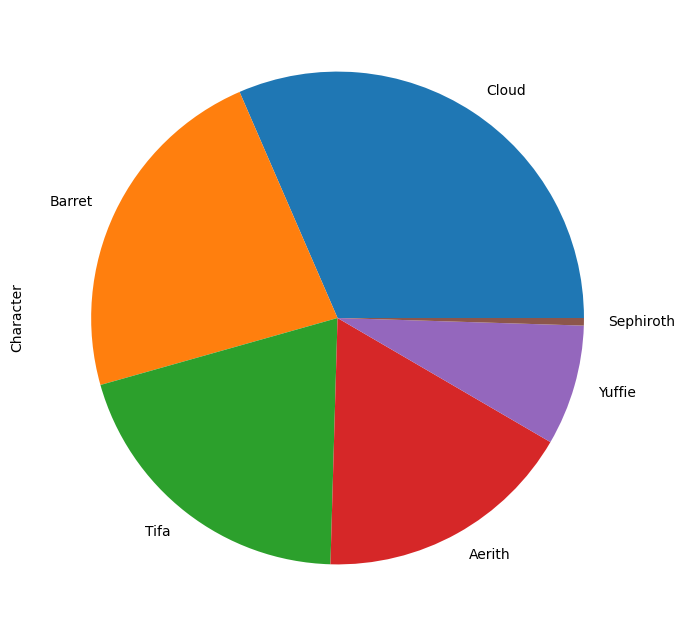

In [ ]:
df_org.Character.value_counts().plot(kind='pie', figsize=(8,8))

In [ ]:
bertTokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
SIZE=df_org.shape[0]
train_dialogue=list(df_org.Dialogue[:SIZE//2])
val_dialogue=list(df_org.Dialogue[SIZE//2:(3*SIZE)//4 ])
test_dialogue=list(df_org.Dialogue[(3*SIZE)//4:])
train_labels=list(df_org.labels[:SIZE//2])
val_labels=list(df_org.Dialogue[SIZE//2:(3*SIZE)//4 ])
test_labels=list(df_org.Dialogue[(3*SIZE)//4:])

In [ ]:
len(train_dialogue), len(val_dialogue), len(test_dialogue)

(2339, 1169, 1170)

In [ ]:
train_encodings = bertTokenizer(train_dialogue, truncation=True, padding=True)
val_encodings = bertTokenizer(val_dialogue, truncation=True, padding=True)
test_encodings = bertTokenizer(test_dialogue, truncation=True, padding=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()


class DialogueDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        encoded_labels = label_encoder.fit_transform(self.labels)

    def __getitem__(self, idx):
      encoded_labels = label_encoder.fit_transform(self.labels)
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(encoded_labels[idx])
      return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataloader = DialogueDataset(train_encodings, train_labels)
val_dataloader = DialogueDataset(val_encodings, val_labels)
test_dataset = DialogueDataset(test_encodings, test_labels)

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
!pip install transformers[torch]
!pip install accelerate
import accelerate
print(accelerate.__version__)

0.29.3


In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids

  preds = pred.predictions.argmax(-1)

  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

  acc = accuracy_score(labels, preds)

  return {
      'Accuracy': acc,
      'F1': f1,
      'Precision': precision,
      'Recall': recall
  }

In [ ]:
training_args = TrainingArguments (
    output_dir='./output',
    do_train=True,
    do_eval=True,

    num_train_epochs=2,
    per_device_train_batch_size=98,
    per_device_eval_batch_size=196,

    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',

    logging_dir='./log',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=False,
    load_best_model_at_end=True
)

In [ ]:
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=48, training_loss=1.6242720286051433, metrics={'train_runtime': 1462.8089, 'train_samples_per_second': 3.198, 'train_steps_per_second': 0.033, 'total_flos': 507256248551688.0, 'train_loss': 1.6242720286051433, 'epoch': 2.0})

# Interactive Game & Evaluation

**Directions: ...**

In [ ]:
import random

In [ ]:
def text_prediction(bert_model, bert_tokenizer, gpt2_model, gpt2_tokenizer, processSwitch, input_text):
    # Get input text from the user
    temper = random.random()
    if processSwitch == 0:
      # Tokenize input text for bert
      input_ids = bert_tokenizer.encode(input_text, add_special_tokens=True, return_tensors="pt")

        # Perform classification using bert
      with torch.no_grad():
        outputs = bert_model(input_ids)
      bert_prediction = torch.argmax(outputs.logits, dim=1).item()
      return bert_prediction

    elif processSwitch == 1:
      # Tokenize input text for gpt2
      input_ids_gpt2 = gpt2_tokenizer.encode(input_text, return_tensors="pt")
      with torch.no_grad():
        gpt2_output = gpt2_model.generate(input_ids_gpt2, max_length=50, num_return_sequences=1, temperature=temper)
      generated_text = gpt2_tokenizer.decode(gpt2_output[0], skip_special_tokens=True)
      return generated_text

#round 1
currChar = -1
victory = 0
while currChar == -1:
  character_select = input("Choose from: Cloud, Barret, Yuffie, Tifa, Aerith, or Sephiroth.")
  if character_select == "Cloud":
    currChar = 0
  elif character_select == "Barret":
    currChar = 1
  elif character_select == "Yuffie":
    currChar = 2
  elif character_select == "Tifa":
    currChar = 3
  elif character_select == "Aerith":
    currChar = 4
  elif character_select == "Sephiroth":
    currChar = 5

input_text = input("Enter text: ")
processSwitch = 0
# Example usage
# Load bert model
bert_model = trainer.model
# Load gp2 model
gpt2_model = gptTrainer.model

# Use the text_prediction function
bert_prediction = text_prediction(bert_model, bertTokenizer, gpt2_model, gptTokenizer, processSwitch, input_text)
print("BERT prediction:", bert_prediction)
processSwitch = 1

# Bert gpt conversion
if bert_prediction == currChar:
  if currChar == 0:
      responsePrompt = "The model guessed you are Cloud correctly. It says:"
  elif currChar == 1:
      responsePrompt = "The model guessed you are Barret correctly. It says:"
  elif currChar == 2:
      responsePrompt = "The model guessed you are Yuffie correctly. It says:"
  elif currChar == 3:
      responsePrompt = "The model guessed you are an Itlaian Senator correctly. It says:"
  elif currChar == 4:
      responsePrompt = "The model guessed you are Aerith correctly. It says:"
  elif currChar == 5:
      responsePrompt = "The model guessed you are Sephiroth correctly. It says:"
  victory = 1

else:
  if bert_prediction == 0:
    character = "Cloud"
    responsePrompt = "The model incorrectly identifies you as Cloud. To identify you it asks:"

  elif bert_prediction == 1:
    character = "Barret"
    responsePrompt = "The model incorrectly identifies you as Barret. To identify you it asks:"

  elif bert_prediction == 2:
    character = "Yuffie"
    responsePrompt = "The model incorrectly identifies you as Yuffie. To identify you it asks:"

  elif bert_prediction == 3:
    character = "Tifa"
    responsePrompt = "The model incorrectly identifies you as Tifa. To identify you it asks:"

  elif bert_prediction == 4:
    character = "Aerith"
    responsePrompt = "The model incorrectly identifies you as Aerith. To identify you it asks:"

  elif bert_prediction == 5:
    character = "Sephiroth"
    responsePrompt = "The model incorrectly identifies you as Sephiroth. To identify you it asks:"

# Tokenize input text for gpt2
input_ids_gpt2 = gptTokenizer.encode(responsePrompt, return_tensors="pt")

generated_text = text_prediction(bert_model, bertTokenizer, gpt2_model, gptTokenizer, processSwitch, responsePrompt)
print("You say:", input_text, "\n", generated_text)

if victory == 0:
  #round 2
  input_text = input("Enter text: ")
  processSwitch = 0
  # Example usage
  # Load bert model
  bert_model = trainer.model
  # Load gp2 model
  gpt2_model = gptTrainer.model

  # Use the text_prediction function
  bert_prediction = text_prediction(bert_model, bertTokenizer, gpt2_model, gptTokenizer, processSwitch, input_text)
  print("BERT prediction:", bert_prediction)
  processSwitch = 1

  # Bert gpt conversion
  if bert_prediction == currChar:
    if currChar == 0:
        responsePrompt = "The model guessed you are Cloud correctly. It says:"
    elif currChar == 1:
        responsePrompt = "The model guessed you are Barret correctly. It says:"
    elif currChar == 2:
        responsePrompt = "The model guessed you are Yuffie correctly. It says:"
    elif currChar == 3:
        responsePrompt = "The model guessed you are an Itlaian Senator correctly. It says:"
    elif currChar == 4:
        responsePrompt = "The model guessed you are Aerith correctly. It says:"
    elif currChar == 5:
        responsePrompt = "The model guessed you are Sephiroth correctly. It says:"
    victory = 1

  else:
    responsePrompt= "The model has lost. In defeat it says:"

  # Tokenize input text for gpt2
  input_ids_gpt2 = gptTokenizer.encode(responsePrompt, return_tensors="pt")

  generated_text = text_prediction(bert_model, bertTokenizer, gpt2_model, gptTokenizer, processSwitch, responsePrompt)
  print("You say:", input_text, "\n", generated_text)

Choose from: Cloud, Barret, Yuffie, Tifa, Aerith, or Sephiroth.Cloud
Enter text: Hmm... I need to find some Materia


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9429097143350544` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


BERT prediction: 0
You say: Hmm... I need to find some Materia 
 The model guessed you are Cloud correctly. It says: "The Cloud is a Cloud."


In [ ]:
input_text = "empty"
def genText(gpt2_model, gpt2_tokenize, input_text, temper):
    # Get input text from the user
      # Tokenize input text for gpt2
      input_ids_gpt2 = gpt2_tokenize.encode(input_text, return_tensors="pt")
      with torch.no_grad():
        gpt2_output = gpt2_model.generate(input_ids_gpt2, max_length=50, num_return_sequences=1, temperature=temper)
      generated_text = gpt2_tokenize.decode(gpt2_output[0], skip_special_tokens=True)
      return generated_text

while input_text != "goodbye":
  input_text = input("Enter text: ")
  temper = random.random()
  responsePrompt = "You say: " + input_text + " The model says:"
  response = genText(gpt2_model, gptTokenizer, responsePrompt, temper)
  print(response)

Enter text: Mother


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.21932075915728333` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


You say: Mother The model says: "I'm not a fan of the idea of a'real' world."


KeyboardInterrupt: Interrupted by user

In [ ]:
input_text = "empty"
def genText(gpt2_model, gpt2_tokenize, input_text, temper):
    # Get input text from the user
      # Tokenize input text for gpt2
      input_ids_gpt2 = gpt2_tokenize.encode(input_text, return_tensors="pt")
      with torch.no_grad():
        gpt2_output = gpt2_model.generate(input_ids_gpt2, max_length=50, num_return_sequences=1, temperature=temper)
      generated_text = gpt2_tokenize.decode(gpt2_output[0], skip_special_tokens=True)
      return generated_text

while input_text != "goodbye":
  input_text = input("Enter text: ")
  temper = random.random()
  response = genText(gpt2_model, gptTokenizer, input_text, temper)
  print(response)

Enter text: Mother


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9975376064951103` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Mother, I'm sorry.
Enter text: Mother


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5095262936764645` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Mothererith: I'm not a fan of the idea of a "real" world.
Enter text: Never gonna


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.09090941217379389` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Never gonna say I'm a fan.
Enter text: Final Fantasy


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.04711637542473457` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Final Fantasy: The Seventh Heavens
Enter text: Final Fantasy


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.10964913035065915` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Final Fantasy: I'm not sure.
Enter text: Final Fantasy


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.62744604170309` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Final Fantasy: You're right.
Enter text: I m


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7920793643629641` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I m'amma, I'm not a fan of the idea of you having to do this.
Enter text: Chocobo


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.42215996679968404` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Chocobo: I'm not sure.
Enter text: chocobo


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.06352770615195713` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


chocobo: I'm not a fan of the idea of a "chocobo."
Enter text: what is a chocobo


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.38161928650653676` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


what is a chocobo anyway?
Enter text: materia


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9961213802400968` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


materia: I'm not sure what to do.
Enter text: Materia


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.529114345099137` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Materia: I'm not sure I can say this.
Enter text: Reactor


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9710783776136181` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Reactor: I'm not a fan of the idea of a "retroactive" reactor.
Enter text: Shinra Sector


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8607797022344981` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Shinra Sector: I'm sure.
Enter text: Shinra


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.011481021942819636` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Shinra: I'm not sure how much I can say.
